# **TCN Fused Decision**

Since the fused decision had better performance on both an Accuracy and ROC AUC basis for the LSTM model compared to the simpler architecture - we will implement a similar architecture using three TCN models to take in the time series data of the three feature subsets and combine the outputs with a Linear layer.

The design of the Temporal Blocks will be the same as designed previously.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.nn.utils.parametrizations as param
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import itertools
import json
import pickle

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install optuna
import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Handling data**

In [ ]:
class MultiInputTimeSeriesDataset(Dataset):
    """
    A custom PyTorch Dataset class for time series data with multiple input sequences.

    Args:
        low_sequences (numpy.ndarray): Low-frequency sequences.
        medium_sequences (numpy.ndarray): Medium-frequency sequences.
        high_sequences (numpy.ndarray): High-frequency sequences.
        labels (numpy.ndarray): Corresponding labels for the sequences.

    Methods:
        __len__(): Returns the number of samples in the dataset.
        __getitem__(idx): Returns a dictionary containing the sequences and label for the given index.
    """
    def __init__(self, low_sequences, medium_sequences, high_sequences, labels):
        self.low_sequences = low_sequences
        self.medium_sequences = medium_sequences
        self.high_sequences = high_sequences
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'low_freq_sequence': torch.tensor(self.low_sequences[idx].transpose(1, 0), dtype=torch.float32),
            'medium_freq_sequence': torch.tensor(self.medium_sequences[idx].transpose(1, 0), dtype=torch.float32),
            'high_freq_sequence': torch.tensor(self.high_sequences[idx].transpose(1, 0), dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_multi_input_data_loaders(low_freq_train_sequences,
                                    medium_freq_train_sequences,
                                    high_freq_train_sequences,
                                    train_labels,
                                    low_freq_val_sequences,
                                    medium_freq_val_sequences,
                                    high_freq_val_sequences,
                                    val_labels,
                                    low_freq_test_sequences,
                                    medium_freq_test_sequences,
                                    high_freq_test_sequences,
                                    test_labels,
                                    batch_size):
    """
    Creates PyTorch DataLoader objects for training, validation, and test sets with multiple inputs.

    Args:
        low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences: Training sequences.
        train_labels: Training labels for all sequences.
        low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences: Validation sequences.
        val_labels: Validation labels for all sequences.
        low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences: Test sequences.
        test_labels: Test labels for all sequences.
        batch_size: Batch size for the DataLoaders.

    Returns:
        tuple: A tuple containing the train, validation, and test DataLoaders.
    """
    train_dataset = MultiInputTimeSeriesDataset(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, train_labels)
    val_dataset = MultiInputTimeSeriesDataset(low_freq_val_sequences, medium_freq_val_sequences, high_freq_val_sequences, val_labels)
    test_dataset = MultiInputTimeSeriesDataset(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Undersampling and Oversampling**

In [ ]:
import numpy as np
from sklearn.utils import resample

def undersample_data(low_sequences, labels, medium_sequences, high_sequences):
    """
    Undersamples the data by randomly reducing the majority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        labels (np.ndarray): Corresponding labels for sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.

    Returns:
        tuple: Undersampled sequences and labels for low, medium, and high frequency data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly undersample the majority class
    undersampled_majority_indices = resample(majority_indices, replace=False, n_samples=len(minority_indices), random_state=42)

    # Combine minority and undersampled majority indices
    undersampled_indices = np.concatenate([minority_indices, undersampled_majority_indices])

    # Get the undersampled sequences and labels
    low_sequences_resampled = low_sequences[undersampled_indices]
    labels_resampled = labels[undersampled_indices]
    medium_sequences_resampled = medium_sequences[undersampled_indices]
    high_sequences_resampled = high_sequences[undersampled_indices]

    return low_sequences_resampled, labels_resampled, medium_sequences_resampled, high_sequences_resampled

def oversample_data(low_sequences, labels, medium_sequences, high_sequences):
    """
    Oversamples the data by duplicating the minority class samples.

    Args:
        low_sequences (np.ndarray): Low frequency sequences.
        labels (np.ndarray): Corresponding labels for sequences.
        medium_sequences (np.ndarray): Medium frequency sequences.
        high_sequences (np.ndarray): High frequency sequences.

    Returns:
        tuple: Oversampled sequences and labels for low, medium, and high frequency data.
    """
    # Identify the minority and majority classes
    minority_class = min(set(labels), key=list(labels).count)
    majority_class = max(set(labels), key=list(labels).count)

    # Split the data into minority and majority classes
    minority_indices = np.where(labels == minority_class)[0]
    majority_indices = np.where(labels == majority_class)[0]

    # Randomly oversample the minority class
    oversampled_minority_indices = resample(minority_indices, replace=True, n_samples=len(majority_indices), random_state=42)

    # Combine majority and oversampled minority indices
    oversampled_indices = np.concatenate([majority_indices, oversampled_minority_indices])

    # Get the oversampled sequences and labels
    low_sequences_resampled = low_sequences[oversampled_indices]
    labels_resampled = labels[oversampled_indices]
    medium_sequences_resampled = medium_sequences[oversampled_indices]
    high_sequences_resampled = high_sequences[oversampled_indices]

    return low_sequences_resampled, labels_resampled, medium_sequences_resampled, high_sequences_resampled

**Early Stopping**

In [ ]:
class EarlyStopping:
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.output_path)

### **Define the Fused TCN model**

The architecture is based on Bai et al. (https://arxiv.org/pdf/1803.01271) and Catling et al. (https://pubmed.ncbi.nlm.nih.gov/31858114/) with added multiple layers and masking.

Chomp1d, Temporal Block and TCN classes remain the same as they are independent of the subsets and masking.

The Fused model uses multiple TCN objects.

In [ ]:
# Class designed to trim the end of a sequence - ensuring output length matches input length after padding and dilations
class Chomp1d(nn.Module):
  def __init__(self, chomp_size):
    super(Chomp1d, self).__init__()
    self.chomp_size = chomp_size # The number of elements to remove from the end of the sequence

  def forward(self, x):
    return x[:, :, :-self.chomp_size].contiguous() # Returns the trimmed sequence

In [ ]:
class TemporalBlock(nn.Module):
  def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout):
    super(TemporalBlock, self).__init__()

    # First dilated convolutional layer
    self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                       stride=stride, padding=padding, dilation=dilation)
    self.chomp1 = Chomp1d(padding) # Trim the output of conv 1 to remove padding added for dilation
    self.relu1 = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(n_outputs) # Batch normlisation to make training more robust
    self.dropout1 = nn.Dropout(dropout) # Spatial dropout

    # Second dilated convolutional layer
    self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                       stride=stride, padding=padding, dilation=dilation)
    self.chomp2 = Chomp1d(padding) # Trim the output of conv 2 to remove padding added for dilation
    self.relu2 = nn.ReLU()
    self.bn2 = nn.BatchNorm1d(n_outputs) # Batch normlisation to make training more robust
    self.dropout2 = nn.Dropout(dropout) # Spatial dropout

    # Sequential container
    self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.bn1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.bn2, self.dropout2)

    # 1x1 convolutional layer for downsampling if the number of input channels is not equal to the number of output channels
    self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
    self.relu = nn.ReLU()
    self.init_weights()

  # Function to initialize weights of the convolutional layers
  def init_weights(self):
    for layer in self.net:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_normal_(layer.weight)  # Use Kaiming Normal initialization
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)  # Initialize biases to 0
    if self.downsample is not None:
        nn.init.kaiming_normal_(self.downsample.weight)  # Use Kaiming Normal initialization for downsample
        if self.downsample.bias is not None:
            nn.init.constant_(self.downsample.bias, 0)  # Initialize biases to 0

  # Define forward pass funcion
  def forward(self, x):
    out = self.net(x) # Pass input through the sequential container
    res = x if self.downsample is None else self.downsample(x) # If the number of input channels is not equal to the number of output channels, use the 1x1 convolutional layer to downsample the input
    return self.relu(out + res) # Add the residual connection and pass the output through a ReLU activation function

In [ ]:
class TCN(nn.Module):
  def __init__(self, num_inputs, num_channels, kernel_size, dropout, seq_length):
    super(TCN, self).__init__()

    layers = []
    num_levels = len(num_channels) # Number of temporal blocks

    for i in range(num_levels):
      dilation_size = 2 ** i # Dilation factor for each temporal block
      in_channels = num_inputs if i == 0 else num_channels[i-1] # Input channels as either num_inputs or output channels from previous block
      out_channels = num_channels[i] # Output channels for current block

      # Append temporal blocks to create network layers
      layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                               dilation=dilation_size, padding=(kernel_size-1) * dilation_size, dropout=dropout)]

      # Stride kept at 1 to preserve sequence length of temporal data and maintain casual convolutions

      # Create sequential container
      self.network = nn.Sequential(*layers)
      # self.linear = nn.Linear(num_channels[-1] * seq_length, 1) # Linear layer for output

      # Debugging layers
      self.final_conv = nn.Conv1d(num_channels[-1], num_channels[-1], 1)

      # self.feature_adjust = nn.Linear(num_channels[-1], num_channels[-1]) # Linear layer for feature adjustment

      self.init_weights() # Initialize weights of the network

  # Function to initialize weights of the linear layer
  def init_weights(self):
    for layer in self.network:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_normal_(layer.weight)
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)
    if self.final_conv is not None:
        nn.init.kaiming_normal_(self.final_conv.weight)
        if self.final_conv.bias is not None:
            nn.init.constant_(self.final_conv.bias, 0)

  # Define forward pass function
  def forward(self, x):
    x = self.network(x) # Pass input through the network layers
    x = self.final_conv(x) # Apply final convolution to the output of the network layers
    # x = x.view(x.size(0), -1) # Flatten the output of the network layers
    # x = self.feature_adjust(x) # Apply feature adjustment to the flattened output


    # x = x.view(x.size(0), -1) # Flatten the output of the network layers
    # x = self.linear(x) # Pass through linear layer
    return x

TCN model no longer outputs a single value but a vector of outputs.

Fused TCN - handles the three data subsets and masking where values were not present in the initial data.

In [ ]:
class FusedTCNModel(nn.Module):
  def __init__(self, low_input_dim, medium_input_dim, high_input_dim, num_channels, kernel_size, dropout, seq_lengths):
    super(FusedTCNModel, self).__init__()

    # Define the TCN layers for the subsets
    self.low_tcn = TCN(low_input_dim, num_channels, kernel_size, dropout, seq_lengths['low'])
    self.medium_tcn = TCN(medium_input_dim, num_channels, kernel_size, dropout, seq_lengths['medium'])
    self.high_tcn = TCN(high_input_dim, num_channels, kernel_size, dropout, seq_lengths['high'])

    # Define the fully connected and sigmoid layers
    self.fc = nn.Linear(num_channels[-1] * 3, 1) # Linear layer for fused output
    self.sigmoid = nn.Sigmoid() # Sigmoid activation function for binary classification

  def forward(self, low_x, medium_x, high_x):

    # Create masks and handle NaNs
    low_mask = ~low_x.isnan()
    medium_mask = ~medium_x.isnan()
    high_mask = ~high_x.isnan()

    # Set NaNs to zeroes to be passed through model
    low_x = torch.where(low_mask, low_x, torch.zeros_like(low_x))
    medium_x = torch.where(medium_mask, medium_x, torch.zeros_like(medium_x))
    high_x = torch.where(high_mask, high_x, torch.zeros_like(high_x))

    # Pass through TCN layers
    low_out = self.low_tcn(low_x)
    medium_out = self.medium_tcn(medium_x)
    high_out = self.high_tcn(high_x)

    # Get the last valid output for each sequence
    def get_last_valid_output(output, mask):
        mask = mask[:, :, 0]  # Reduce mask to 2D
        last_valid_index = mask.sum(dim=1) - 1

        # Ensure last_valid_index is within the valid range
        last_valid_index = torch.clamp(last_valid_index, min=0, max=output.size(2) - 1)

        # Use gather to get the last valid output
        batch_size, feat_dim = output.size(0), output.size(1)
        last_valid_index = last_valid_index.unsqueeze(1).unsqueeze(2).expand(batch_size, feat_dim, 1)
        last_valid_output = output.gather(2, last_valid_index).squeeze(2)
        return last_valid_output

    low_out_last = get_last_valid_output(low_out, low_mask)
    medium_out_last = get_last_valid_output(medium_out, medium_mask)
    high_out_last = get_last_valid_output(high_out, high_mask)

    # Concatenate outputs from TCNs
    out = torch.cat((low_out_last, medium_out_last, high_out_last), dim=1)

    # Apply fully connected layer to fuse outputs
    out = self.fc(out.view(out.size(0), -1))

    # Apply sigmoid or binary classification
    out = self.sigmoid(out)

    return out

**Model training**

In [ ]:
def train_fused_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    """
    Train the fused LSTM model with early stopping and logging.

    Parameters:
    model (nn.Module): The fused LSTM model to be trained.
    train_loader (DataLoader): DataLoader for the training data.
    val_loader (DataLoader): DataLoader for the validation data.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim.Optimizer): Optimizer.
    num_epochs (int): Number of epochs to train the model.
    device (torch.device): Device to run the model on (CPU or GPU).
    patience (int): Number of epochs to wait for improvement before stopping early.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    model (nn.Module): The trained LSTM model.
    train_losses (list): List of training losses per epoch.
    val_losses (list): List of validation losses per epoch.
    val_aucs (list): List of validation AUC scores per epoch.
    """
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    early_stopping = EarlyStopping(output_path, patience=patience, min_delta=0)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            loss.backward()

            # Add gradient clipping to prevent exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []

        with torch.no_grad():
            for data in val_loader:
                low_freq_sequences = data['low_freq_sequence'].to(device)
                medium_freq_sequences = data['medium_freq_sequence'].to(device)
                high_freq_sequences = data['high_freq_sequence'].to(device)
                labels = data['label'].to(device).view(-1, 1)

                outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * low_freq_sequences.size(0)

                val_outputs.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)

        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

**Cross validation**

In [ ]:
def shuffle_data(sequences, labels):
    assert len(sequences) == len(labels)
    p = np.random.permutation(len(sequences))
    return sequences[p], labels[p]

def split_data_into_folds(sequences, labels, num_folds):
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    labels_folds = []
    for i in range(num_folds):
        start_idx = i * fold_size
        if i == num_folds - 1:  # Make sure the last fold includes any remaining data points
            end_idx = len(sequences)
        else:
            end_idx = start_idx + fold_size
        sequences_folds.append(sequences[start_idx:end_idx])
        labels_folds.append(labels[start_idx:end_idx])
    return sequences_folds, labels_folds

In [ ]:
def reset_model(model):
    """
    Reset the parameters of the model to their initial values.

    Parameters:
    model (nn.Module): The model whose parameters need to be reset.
    """
    def reset_parameters(layer):
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

    def reset_tcn_parameters(tcn_model):
        for layer in tcn_model.children():
            if isinstance(layer, nn.Sequential):
                for sub_layer in layer:
                    reset_parameters(sub_layer)
            else:
                reset_parameters(layer)

    # Reset parameters for the main model
    reset_parameters(model)

    # Reset parameters for each TCN in the FusedTCNModel
    reset_tcn_parameters(model.low_tcn)
    reset_tcn_parameters(model.medium_tcn)
    reset_tcn_parameters(model.high_tcn)

    # Reset parameters for fully connected and sigmoid layers
    for layer in model.fc.children():
        reset_parameters(layer)
    reset_parameters(model.sigmoid)

In [ ]:
def manual_cross_validation(low_sequences, medium_sequences, high_sequences, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    """
    Perform manual cross-validation for the fused LSTM model.

    Parameters:
    low_sequences (np.array): Low frequency sequences.
    medium_sequences (np.array): Medium frequency sequences.
    high_sequences (np.array): High frequency sequences.
    labels (np.array): Labels for sequences.
    hyperparameters (list): List of hyperparameter dictionaries to evaluate.
    num_folds (int): Number of folds for cross-validation. Default is 5.
    patience (int): Number of epochs to wait for improvement before stopping early. Default is 5.
    output_path (str): Path to save the best model checkpoint.

    Returns:
    tuple: Best model, best hyperparameters, best AUC score.
    """
    # Shuffle and split the data into folds
    low_sequences, labels = shuffle_data(low_sequences, labels)
    medium_sequences, _ = shuffle_data(medium_sequences, labels)
    high_sequences, _ = shuffle_data(high_sequences, labels)

    low_sequences_folds, labels_folds = split_data_into_folds(low_sequences, labels, num_folds)
    medium_sequences_folds, _ = split_data_into_folds(medium_sequences, labels, num_folds)
    high_sequences_folds, _ = split_data_into_folds(high_sequences, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        # Separate into train and validation sets
        val_low_sequences = low_sequences_folds[i]
        val_labels = labels_folds[i]
        train_low_sequences = np.concatenate([low_sequences_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        val_medium_sequences = medium_sequences_folds[i]
        train_medium_sequences = np.concatenate([medium_sequences_folds[j] for j in range(num_folds) if j != i])

        val_high_sequences = high_sequences_folds[i]
        train_high_sequences = np.concatenate([high_sequences_folds[j] for j in range(num_folds) if j != i])

        for params in hyperparameters:
            # Handle sampling methods
            if params['sampling_method'] == 'undersample':
                train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = undersample_data(
                    train_low_sequences, train_labels, train_medium_sequences, train_high_sequences
                )
            elif params['sampling_method'] == 'oversample':
                train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = oversample_data(
                    train_low_sequences, train_labels, train_medium_sequences, train_high_sequences
                )
            else:
                train_low_sequences_resampled, train_labels_resampled = train_low_sequences, train_labels
                train_medium_sequences_resampled, train_high_sequences_resampled = train_medium_sequences, train_high_sequences

            # Create data loaders for each subset using the provided function
            train_loader, val_loader, _ = create_multi_input_data_loaders(
                train_low_sequences_resampled,
                train_medium_sequences_resampled,
                train_high_sequences_resampled,
                train_labels_resampled,
                val_low_sequences,
                val_medium_sequences,
                val_high_sequences,
                val_labels,
                val_low_sequences, # Placeholder
                val_medium_sequences, # Placeholder
                val_high_sequences, # Placeholder
                val_labels, # Placeholder
                batch_size=params['batch_size']
            )

            # Determine the input_dim for each subset
            low_input_dim = train_low_sequences.shape[2]
            medium_input_dim = train_medium_sequences.shape[2]
            high_input_dim = train_high_sequences.shape[2]

            # Initialize the model
            model = FusedTCNModel(
                low_input_dim=low_input_dim,
                medium_input_dim=medium_input_dim,
                high_input_dim=high_input_dim,
                num_channels=params['num_channels'],
                kernel_size=params['kernel_size'],
                dropout=params['dropout'],
                seq_lengths={
                    'low': train_low_sequences.shape[1],
                    'medium': train_medium_sequences.shape[1],
                    'high': train_high_sequences.shape[1]
                }
            ).to(device)

            # Reset the model parameters
            reset_model(model)

            # Define the loss function
            criterion = nn.BCELoss()

            # Apply weighted loss function if indicated and where sampling is not over or undersampling
            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # Create weighted loss

            # Define the optimizer with learning rate and L2 weight decay
            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            # Train the model with early stopping and logging
            model, train_losses, val_losses, val_aucs = train_fused_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            # Evaluate the model
            val_outputs = []
            val_labels_list = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    low_freq_sequences = data['low_freq_sequence'].to(device)
                    medium_freq_sequences = data['medium_freq_sequence'].to(device)
                    high_freq_sequences = data['high_freq_sequence'].to(device)
                    labels_batch = data['label'].to(device).view(-1, 1)
                    outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels_list.extend(labels_batch.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels_list, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    # Plot training and validation loss and AUC for the best model
    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(16, 6))

        # Plot training and validation loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plot validation AUC
        plt.subplot(1, 2, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc

**Bayesian Objective Function**

In [ ]:
# Run Bayesian optimization
def objective_wrapper(low_train_sequences, medium_train_sequences, high_train_sequences, train_labels, hyperparameter_grid):
    def objective(trial):
        num_channels_str = trial.suggest_categorical('num_channels', hyperparameter_grid['num_channels'])
        num_channels = tuple(map(int, num_channels_str.split(',')))

        kernel_size = trial.suggest_int('kernel_size', min(hyperparameter_grid['kernel_size']), max(hyperparameter_grid['kernel_size']))
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_int('num_epochs', min(hyperparameter_grid['num_epochs']) // 10, max(hyperparameter_grid['num_epochs']) // 10) * 10
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'num_channels': num_channels,
            'kernel_size': kernel_size,
            'dropout': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay,
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            low_train_sequences,
            medium_train_sequences,
            high_train_sequences,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

**Final model training**

In [ ]:
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """
    Train the model with the given parameters.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            running_loss += loss.item() * low_freq_sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')


    # Plot the training losses at the end of training
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

    return model, train_losses

**Evaluate final model**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The neural network model to be evaluated.
    test_loader (DataLoader): The DataLoader for the test dataset.
    device (torch.device): The device to evaluate the model on.

    Returns:
    tuple: A tuple containing the evaluation metrics (accuracy, precision, recall, f1, roc_auc, specificity).
    """
    model.to(device)
    model.eval()
    test_outputs = []
    test_labels = []

    with torch.no_grad():
        for data in test_loader:
            # Get the input sequences and labels
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return (accuracy, precision, recall, f1, roc_auc, specificity), test_outputs

**Load the data**

In [ ]:
# Load the sequences and labels
low_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_frequency_train_sequences_v1.npy'
medium_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/medium_frequency_train_sequences_v1.npy'
high_train_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/high_frequency_train_sequences_v1.npy'
labels_train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_frequency_train_labels_v1.npy'

low_freq_train_sequences = np.load(low_train_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_train_sequences = np.load(medium_train_seq_path, allow_pickle=True).astype(np.float32)
high_freq_train_sequences = np.load(high_train_seq_path, allow_pickle=True).astype(np.float32)
labels_train = np.load(labels_train_path, allow_pickle=True).astype(np.float32)

print("Low frequency sequences shape:", low_freq_train_sequences.shape)
print("Medium frequency sequences shape:", medium_freq_train_sequences.shape)
print("High frequency sequences shape:", high_freq_train_sequences.shape)
print("Labels shape:", labels_train.shape)

Low frequency sequences shape: (3760, 4, 3)
Medium frequency sequences shape: (3760, 7, 10)
High frequency sequences shape: (3760, 13, 6)
Labels shape: (3760,)


# **Experiment 1**

We will now run our first experiment using Bayesian Optimisation to tune hyperparameters and then train the final model.

As before, we will be using a global set of hyperparameters rather than local params for each TCN layer in the interest of computational efficiency and resource use.

**Define the Hyperparameter Grid**

In [ ]:
# Hyperparameter grid
param_grid_exp_1 = {
    'num_channels': [
        '16,32', '32,64', '64,128', '128,256',
        '16,32,64', '32,64,128', '64,128,256'
    ],
    'kernel_size': list(range(2, 11)),  # Kernel sizes from 2 to 10
    'dropout_prob': [0.0, 0.2, 0.4, 0.6, 0.8],
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2]
}

param_combinations = list(itertools.product(*param_grid_exp_1.values()))

param_combinations = [dict(zip(param_grid_exp_1.keys(), combination))
  for combination in param_combinations]


print(f"Number of hyperparameter combinations: {len(param_combinations)}")

Number of hyperparameter combinations: 1512000


**Run Bayesian Optimisation**

In [ ]:
# Run Bayesian Optimisation for Hyperparameter Tuning
study_exp_1 = optuna.create_study(direction='minimize')
study_exp_1.optimize(objective_wrapper(low_freq_train_sequences, medium_freq_train_sequences, high_freq_train_sequences, labels_train, param_grid_exp_1), n_trials=100)

best_params = study_exp_1.best_trial.params
print("Best hyperparameters:", best_params)

# Save the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/02_feature_set_2/02_tcn_fused_decision/dynamic_data/best_models/experiment_1/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

best_score = study_exp_1.best_trial.value
print("Best score:", best_score)

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'num_channels': '64,128', 'kernel_size': 2, 'dropout_prob': 0.2, 'learning_rate': 0.0001, 'batch_size': 64, 'num_epochs': 9, 'sampling_method': 'oversample', 'loss': 'normal', 'weight_decay': 0.01}


Best score: -0.5832161658437695

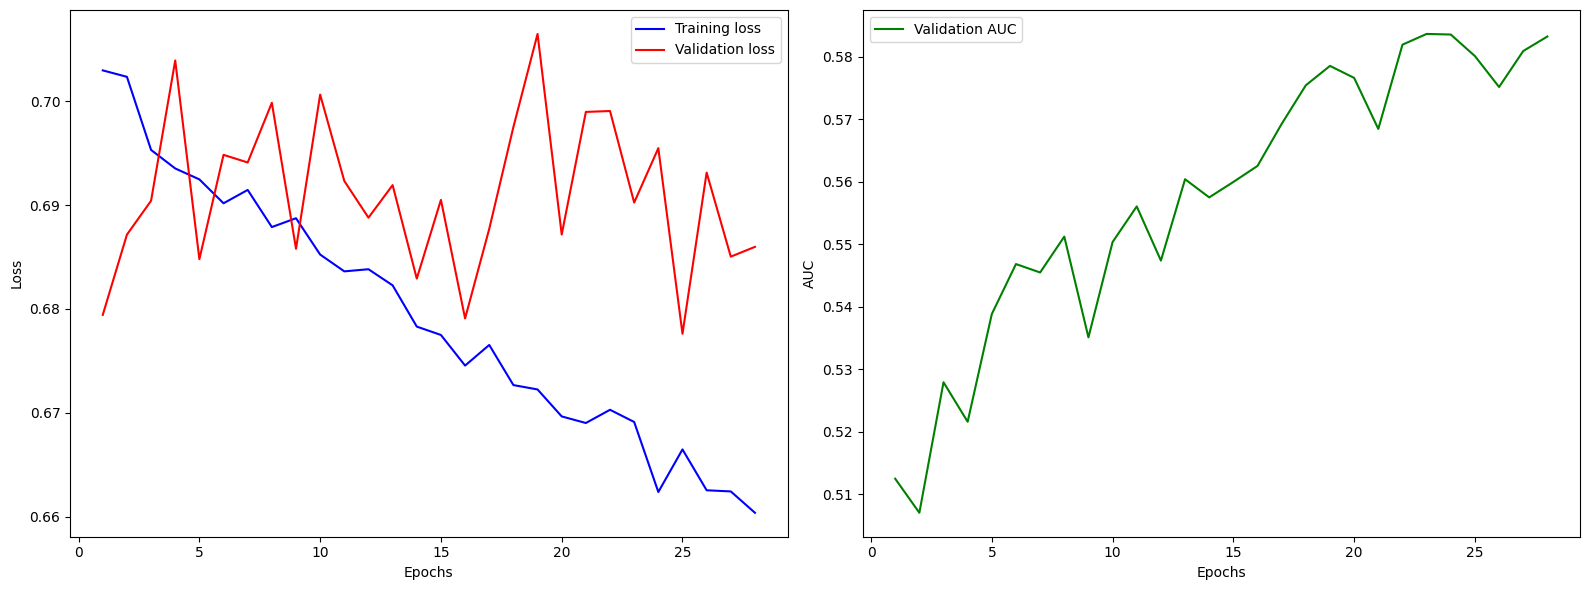

In [ ]:
best_params = {'num_channels': '64,128',
 'kernel_size': 2,
 'dropout_prob': 0.2,
 'learning_rate': 0.0001,
 'batch_size': 64,
 'num_epochs': 9,
 'sampling_method': 'oversample',
 'loss': 'normal',
 'weight_decay': 0.01}

In [ ]:
# Set num_epochs within best params to 10
best_params['num_epochs'] = 10
best_params

{'num_channels': '64,128',
 'kernel_size': 2,
 'dropout_prob': 0.2,
 'learning_rate': 0.0001,
 'batch_size': 64,
 'num_epochs': 10,
 'sampling_method': 'oversample',
 'loss': 'normal',
 'weight_decay': 0.01}

We can now train and evaluate the final model.

### **Final model training**

In [ ]:
# Load the test sequences
low_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_frequency_test_sequences_v1.npy'
medium_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/medium_frequency_test_sequences_v1.npy'
high_test_seq_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/high_frequency_test_sequences_v1.npy'

# Load the test labels
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_frequency_test_labels_v1.npy'

low_freq_test_sequences = np.load(low_test_seq_path, allow_pickle=True).astype(np.float32)
medium_freq_test_sequences = np.load(medium_test_seq_path, allow_pickle=True).astype(np.float32)
high_freq_test_sequences = np.load(high_test_seq_path, allow_pickle=True).astype(np.float32)

labels_test = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

print(f'Low frequency test sequences shape: {low_freq_test_sequences.shape}')
print(f'Medium frequency test sequences shape: {medium_freq_test_sequences.shape}')
print(f'High frequency test sequences shape: {high_freq_test_sequences.shape}')
print(f'Test labels shape: {labels_test.shape}')

Low frequency test sequences shape: (941, 4, 3)
Medium frequency test sequences shape: (941, 7, 10)
High frequency test sequences shape: (941, 13, 6)
Test labels shape: (941,)


In [ ]:
final_model = FusedTCNModel(
    low_input_dim=low_freq_train_sequences.shape[2],
    medium_input_dim=medium_freq_train_sequences.shape[2],
    high_input_dim=high_freq_train_sequences.shape[2],
    num_channels=[int(x) for x in best_params['num_channels'].split(',')],
    kernel_size=best_params['kernel_size'],
    dropout=best_params['dropout_prob'],
    seq_lengths={
        'low': low_freq_train_sequences.shape[1],
        'medium': medium_freq_train_sequences.shape[1],
        'high': high_freq_train_sequences.shape[1]
    }
).to(device)

final_model

FusedTCNModel(
  (low_tcn): TCN(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(3, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(3, 64, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (4): Dropout(p=0.2, inplace=False)
          (5): Conv1d(64, 64, kernel_size=(2,), stride=(1,), padding=(1,))
    

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'oversampling':
  train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = oversample_data(
      low_freq_train_sequences, labels_train, medium_freq_train_sequences, high_freq_train_sequences
  )
elif best_params['sampling_method'] == 'undersampling':
  train_low_sequences_resampled, train_labels_resampled, train_medium_sequences_resampled, train_high_sequences_resampled = undersample_data(
      low_freq_train_sequences, labels_train, medium_freq_train_sequences, high_freq_train_sequences
  )
else:
  train_low_sequences_resampled = low_freq_train_sequences
  train_medium_sequences_resampled = medium_freq_train_sequences
  train_high_sequences_resampled = high_freq_train_sequences
  train_labels_resampled = labels_train

# Define the loss function
if best_params['loss'] == 'weighted':
    pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
    criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(
    final_model.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_model.to(device)

# Create data loaders
train_loader, _, test_loader = create_multi_input_data_loaders(
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    low_freq_test_sequences,
    medium_freq_test_sequences,
    high_freq_test_sequences,
    labels_test,
    batch_size=best_params['batch_size']
)

In [ ]:
# Create data loaders
train_loader, _, test_loader = create_multi_input_data_loaders(
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    _,
    low_freq_test_sequences,
    medium_freq_test_sequences,
    high_freq_test_sequences,
    labels_test,
    batch_size=best_params['batch_size']
)

Epoch 1/10, Loss: 0.7056
Epoch 2/10, Loss: 0.6695
Epoch 3/10, Loss: 0.6483
Epoch 4/10, Loss: 0.6547
Epoch 5/10, Loss: 0.6375
Epoch 6/10, Loss: 0.6261
Epoch 7/10, Loss: 0.6290
Epoch 8/10, Loss: 0.6194
Epoch 9/10, Loss: 0.6239
Epoch 10/10, Loss: 0.6202


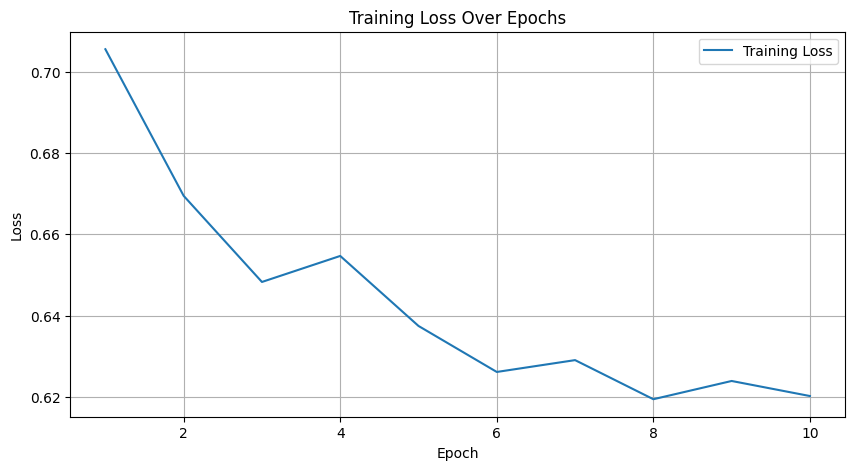

In [ ]:
# Train the final model
final_model, train_losses = train_final_model(
    final_model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device
)

In [ ]:
# Save the final trained model
output_dir = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/02_feature_set_2/02_tcn_fused_decision/dynamic_data/best_models/experiment_1/final_model.pkl'
with open(output_dir, 'wb') as f:
    pickle.dump(final_model, f)

### **Evaluate final model on testing set**

In [ ]:
evaluate_model(final_model, test_loader, device)

Accuracy: 0.6918
Precision: 0.6338
Recall (Sensitivity): 0.1456
F1 Score: 0.2368
ROC AUC: 0.6178
Specificity: 0.9589


(0.691817215727949,
 0.6338028169014085,
 0.14563106796116504,
 0.2368421052631579,
 0.6177747736676088,
 0.9588607594936709)

Accuracy: 0.6918
Precision: 0.6338
Recall (Sensitivity): 0.1456
F1 Score: 0.2368
ROC AUC: 0.6178
Specificity: 0.9589

Ensemble predictions

In [ ]:
output_dir = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/02_feature_set_2/02_tcn_fused_decision/dynamic_data/best_models/experiment_1/final_model.pkl'
with open(output_dir, 'rb') as f:
    final_model = pickle.load(f)

In [ ]:
_, predictions = evaluate_model(final_model, test_loader, device)

Accuracy: 0.6918
Precision: 0.6338
Recall (Sensitivity): 0.1456
F1 Score: 0.2368
ROC AUC: 0.6178
Specificity: 0.9589


In [ ]:
np.save('/content/drive/MyDrive/MSc_Final_Project/03_model_development/02_feature_set_2/02_tcn_fused_decision/dynamic_data/best_models/experiment_1/predictions.npy', predictions)

**Calculate F1 minority**

In [ ]:
def calculate_f1_minority(model, test_loader, device):
    """
    Calculate the F1 score for the minority class.

    Parameters:
    model (nn.Module): Trained LSTM model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    float: F1 score for the minority class.
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            predictions = (outputs >= 0.5).cpu().numpy().astype(int)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions)

    # Calculate F1 score for the minority class (class 1)
    f1_minority = f1_score(all_labels, all_predictions, average='binary', pos_label=1)
    return f1_minority

In [ ]:
calculate_f1_minority(final_model, test_loader, device)

0.2368421052631579

The F1 on the minority class is also extremely low despite accuracy and ROC AUC being high. It may be that F1 score is not a relevant metric when the data is imbalanced.

**Confusion Matrix**

Let's have a look what the confusion matrix looks like for this model evaluation.

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    # Ensure the LSTM weights are compacted
    if hasattr(model, 'lstm'):
        model.lstm.flatten_parameters()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_test_sequences = data['low_freq_sequence'].to(device)
            medium_freq_test_sequences = data['medium_freq_sequence'].to(device)
            high_freq_test_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(low_freq_test_sequences, medium_freq_test_sequences, high_freq_test_sequences)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['extubation_success', 'extubation_failure']  # Replace with your actual class names if different

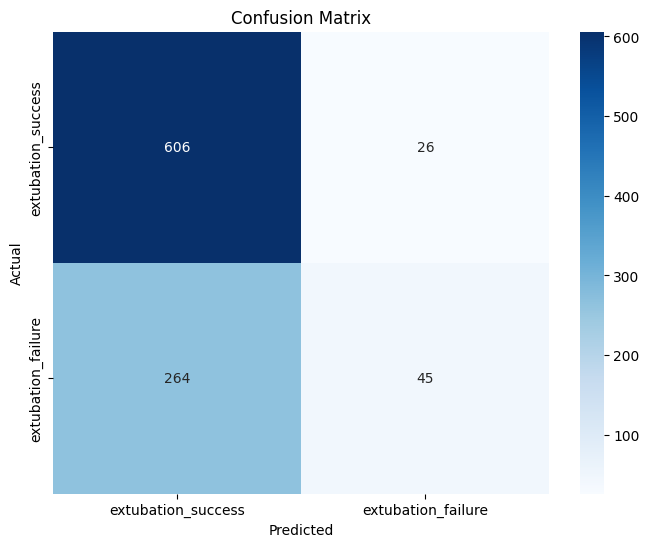

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model, test_loader, device)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

This prediction is comparable to the LSTM with fused decision.

When compared to the simpler TCN model, all predictions were biased towards the failure class which suggested perculiar behaviour and warranted a reconsideration of how the data was processed.

**Classification threshold**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def find_best_threshold_and_evaluate(model, test_loader, device):
    """
    Find the best threshold for binary classification based on ROC AUC and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    dict: A dictionary containing the best threshold, ROC AUC, and other evaluation metrics.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    best_threshold = 0.5
    best_metric_value = 0.0

    thresholds = np.arange(0.0, 1.0, 0.01)  # You can change the step size if needed

    for threshold in thresholds:
        preds = (all_probs >= threshold).astype(int)
        metric_value = roc_auc_score(all_labels, preds)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    # Apply the best threshold to get the final predictions
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    metrics = {
        'best_threshold': best_threshold,
        'best_metric_value': best_metric_value,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'specificity': specificity
    }

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Metric Value: {best_metric_value}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return metrics

In [ ]:
find_best_threshold_and_evaluate(final_model, test_loader, device)

Best Threshold: 0.33
Best Metric Value: 0.5885154233747081
Accuracy: 0.5972
Precision: 0.4163
Recall: 0.5631
F1 Score: 0.4787
ROC AUC: 0.6178
Specificity: 0.6139


{'best_threshold': 0.33,
 'best_metric_value': 0.5885154233747081,
 'accuracy': 0.5972369819341127,
 'precision': 0.41626794258373206,
 'recall': 0.5631067961165048,
 'f1_score': 0.4786795048143053,
 'roc_auc': 0.6177747736676088,
 'specificity': 0.6139240506329114}

This is again comparable to LSTM with Fused decision. Suggests that TCN and LSTM predict learn in an analogous way.

**Plot ROC curve**

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_curve

def plot_roc_curve(model, test_loader, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data in test_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            # Get model output (predicted probabilities)
            output = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc_score(all_labels, all_probs)))
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

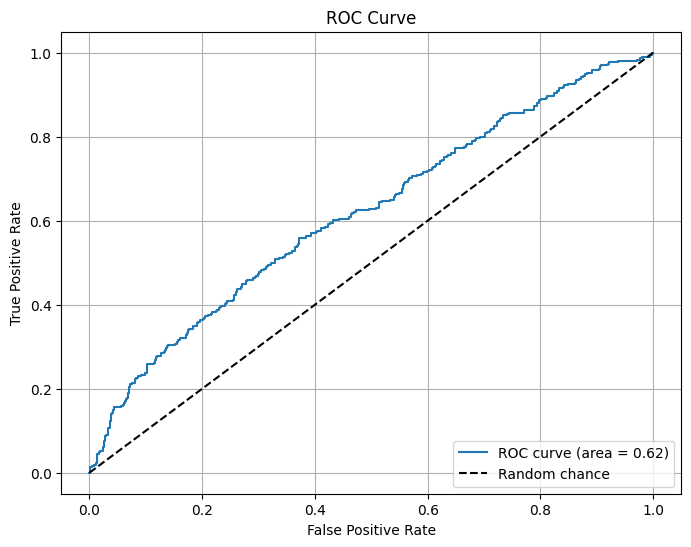

In [ ]:
plot_roc_curve(final_model, test_loader, device)

Curve is better than the straight line shown for similar architecture.

### **Model Interpretability**

We can now implement feature ablation to see feature importance and compare with LSTM fused decision.

In [ ]:
# Load the feature names
low_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/low_freq_feature_names_v1.npy'
medium_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/medium_freq_feature_names_v1.npy'
high_feature_names = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/02_feature_set_2/01_lstm_data/dynamic_data/high_freq_feature_names_v1.npy'

low_freq_feature_names = np.load(low_feature_names, allow_pickle=True)
medium_freq_feature_names = np.load(medium_feature_names, allow_pickle=True)
high_freq_feature_names = np.load(high_feature_names, allow_pickle=True)

print(low_freq_feature_names)
print(medium_freq_feature_names)
print(high_freq_feature_names)

['PH (Arterial)' 'Arterial O2 pressure' 'Arterial CO2 Pressure']
['Inspired O2 Fraction' 'GCS - Eye Opening' 'GCS - Motor Response'
 'Tidal Volume (observed)' 'Minute Volume' 'Mean Airway Pressure'
 'Peak Insp. Pressure' 'Temperature Fahrenheit'
 'Tidal Volume (spontaneous)' 'Richmond-RAS Scale']
['Heart Rate' 'O2 saturation pulseoxymetry' 'Respiratory Rate'
 'Arterial Blood Pressure mean' 'Arterial Blood Pressure diastolic'
 'Arterial Blood Pressure systolic']


In [ ]:
def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            low_freq_sequences = data['low_freq_sequence'].to(device)
            medium_freq_sequences = data['medium_freq_sequence'].to(device)
            high_freq_sequences = data['high_freq_sequence'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            outputs = model(low_freq_sequences, medium_freq_sequences, high_freq_sequences)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    tn, fp, fn, tp = confusion_matrix(all_labels, (np.array(all_outputs) > 0.5).astype(int)).ravel()
    specificity = tn / (tn + fp)

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
def feature_ablation_with_names(low_train_sequences, medium_train_sequences, high_train_sequences, train_labels,
                                low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
                                model, best_hyperparams, device, low_feature_names, medium_feature_names, high_feature_names):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    low_train_sequences (np.array): The low frequency training sequences.
    medium_train_sequences (np.array): The medium frequency training sequences.
    high_train_sequences (np.array): The high frequency training sequences.
    train_labels (np.array): The training labels.
    low_test_sequences (np.array): The low frequency test sequences.
    medium_test_sequences (np.array): The medium frequency test sequences.
    high_test_sequences (np.array): The high frequency test sequences.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained fused TCN model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    low_feature_names (list): List of low frequency feature names.
    medium_feature_names (list): List of medium frequency feature names.
    high_feature_names (list): List of high frequency feature names.

    Returns:
    feature_importances (pd.DataFrame): DataFrame containing the importance of each feature.
    """
    feature_importances = {}

    criterion = nn.BCELoss()
    test_loader = create_multi_input_data_loaders(
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        low_test_sequences, medium_test_sequences, high_test_sequences, test_labels,
        best_hyperparams['batch_size']
    )[2]  # Only get the test loader

    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model, test_loader, criterion, device
    )

    def ablate_and_evaluate(train_sequences, test_sequences, feature_names, subset):
        for feature_idx in range(train_sequences.shape[2]):
            feature_name = feature_names[feature_idx]
            print(f"Ablating feature {feature_name} ({feature_idx + 1}/{train_sequences.shape[2]})")

            # Remove the feature from the sequences
            train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
            test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

            if subset == 0:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    train_sequences_ablation, medium_train_sequences, high_train_sequences, train_labels,
                    train_sequences_ablation, medium_train_sequences, high_train_sequences, train_labels,
                    test_sequences_ablation, medium_test_sequences, high_test_sequences, test_labels,
                    best_hyperparams['batch_size']
                )
            elif subset == 1:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    low_train_sequences, train_sequences_ablation, high_train_sequences, train_labels,
                    low_train_sequences, train_sequences_ablation, high_train_sequences, train_labels,
                    low_test_sequences, test_sequences_ablation, high_test_sequences, test_labels,
                    best_hyperparams['batch_size']
                )
            else:
                train_loader, val_loader, test_loader = create_multi_input_data_loaders(
                    low_train_sequences, medium_train_sequences, train_sequences_ablation, train_labels,
                    low_train_sequences, medium_train_sequences, train_sequences_ablation, train_labels,
                    low_test_sequences, medium_test_sequences, test_sequences_ablation, test_labels,
                    best_hyperparams['batch_size']
                )

            # Initialize a new model for this ablation
            ablation_model = FusedTCNModel(
                low_input_dim=low_train_sequences.shape[2] - (1 if subset == 0 else 0),
                medium_input_dim=medium_train_sequences.shape[2] - (1 if subset == 1 else 0),
                high_input_dim=high_train_sequences.shape[2] - (1 if subset == 2 else 0),
                num_channels=[int(x) for x in best_hyperparams['num_channels'].split(',')],
                kernel_size=best_hyperparams['kernel_size'],
                dropout=best_hyperparams['dropout_prob'],
                seq_lengths={'low': low_train_sequences.shape[1], 'medium': medium_train_sequences.shape[1], 'high': high_train_sequences.shape[1]}
            ).to(device)

            optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'], weight_decay=best_hyperparams['weight_decay'])

            # Train the model
            ablation_model, _ = train_final_model(
                ablation_model, train_loader, criterion, optimizer,
                best_hyperparams['num_epochs'], device
            )

            # Evaluate the model
            _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

            feature_importances[feature_name] = {
                'accuracy': base_accuracy - accuracy,
                'precision': base_precision - precision,
                'recall': base_recall - recall,
                'f1': base_f1 - f1,
                'roc_auc': base_roc_auc - roc_auc,
                'specificity': base_specificity - specificity
            }

    ablate_and_evaluate(low_train_sequences, low_test_sequences, low_feature_names, 0)
    ablate_and_evaluate(medium_train_sequences, medium_test_sequences, medium_feature_names, 1)
    ablate_and_evaluate(high_train_sequences, high_test_sequences, high_feature_names, 2)

    # Convert feature importances to a DataFrame for better readability
    feature_importances_df = pd.DataFrame.from_dict(feature_importances, orient='index')
    feature_importances_df = feature_importances_df.sort_values(by='roc_auc', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(feature_importances_df.index, feature_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return feature_importances_df

Ablating feature PH (Arterial) (1/3)
Epoch 1/10, Loss: 0.7264
Epoch 2/10, Loss: 0.6660
Epoch 3/10, Loss: 0.6521
Epoch 4/10, Loss: 0.6563
Epoch 5/10, Loss: 0.6416
Epoch 6/10, Loss: 0.6296
Epoch 7/10, Loss: 0.6332
Epoch 8/10, Loss: 0.6261
Epoch 9/10, Loss: 0.6231
Epoch 10/10, Loss: 0.6219


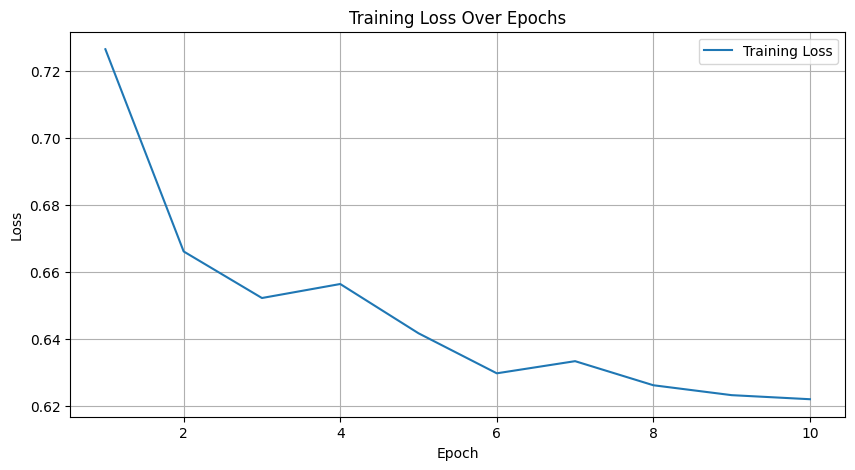

Ablating feature Arterial O2 pressure (2/3)
Epoch 1/10, Loss: 0.6837
Epoch 2/10, Loss: 0.6668
Epoch 3/10, Loss: 0.6541
Epoch 4/10, Loss: 0.6472
Epoch 5/10, Loss: 0.6327
Epoch 6/10, Loss: 0.6362
Epoch 7/10, Loss: 0.6257
Epoch 8/10, Loss: 0.6301
Epoch 9/10, Loss: 0.6225
Epoch 10/10, Loss: 0.6238


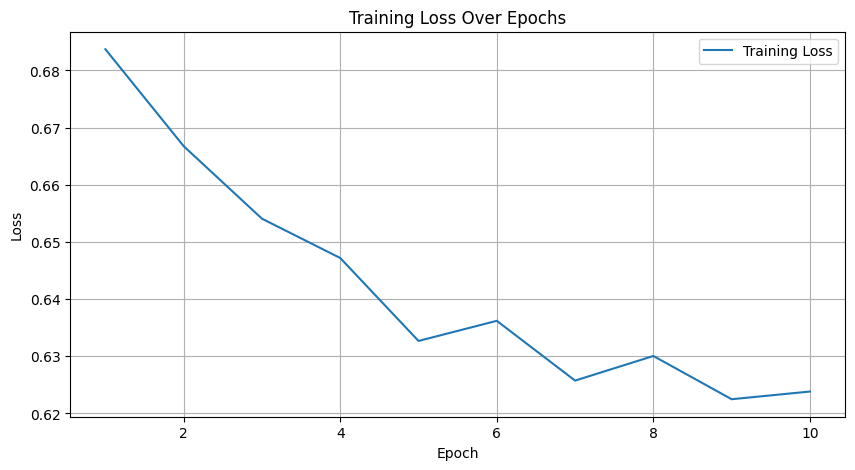

Ablating feature Arterial CO2 Pressure (3/3)
Epoch 1/10, Loss: 0.6878
Epoch 2/10, Loss: 0.6683
Epoch 3/10, Loss: 0.6462
Epoch 4/10, Loss: 0.6429
Epoch 5/10, Loss: 0.6335
Epoch 6/10, Loss: 0.6333
Epoch 7/10, Loss: 0.6219
Epoch 8/10, Loss: 0.6308
Epoch 9/10, Loss: 0.6229
Epoch 10/10, Loss: 0.6192


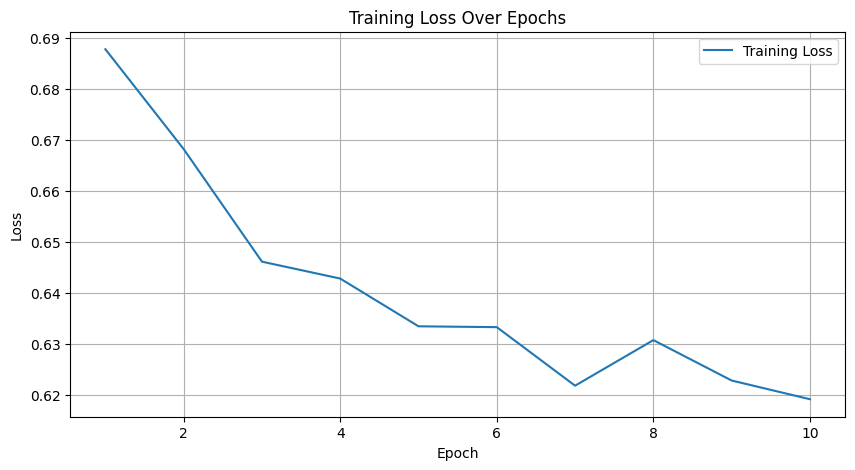

Ablating feature Inspired O2 Fraction (1/10)
Epoch 1/10, Loss: 0.7178
Epoch 2/10, Loss: 0.6721
Epoch 3/10, Loss: 0.6503
Epoch 4/10, Loss: 0.6435
Epoch 5/10, Loss: 0.6346
Epoch 6/10, Loss: 0.6333
Epoch 7/10, Loss: 0.6237
Epoch 8/10, Loss: 0.6314
Epoch 9/10, Loss: 0.6306
Epoch 10/10, Loss: 0.6199


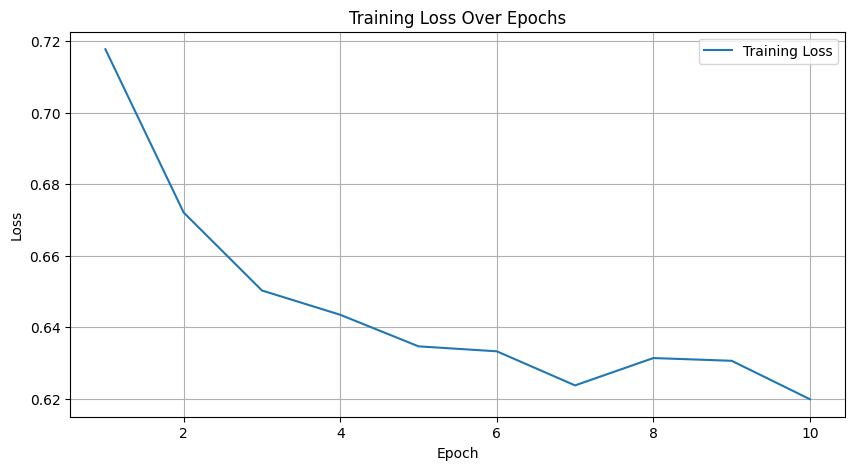

Ablating feature GCS - Eye Opening (2/10)
Epoch 1/10, Loss: 0.7034
Epoch 2/10, Loss: 0.6730
Epoch 3/10, Loss: 0.6584
Epoch 4/10, Loss: 0.6496
Epoch 5/10, Loss: 0.6403
Epoch 6/10, Loss: 0.6383
Epoch 7/10, Loss: 0.6342
Epoch 8/10, Loss: 0.6264
Epoch 9/10, Loss: 0.6251
Epoch 10/10, Loss: 0.6197


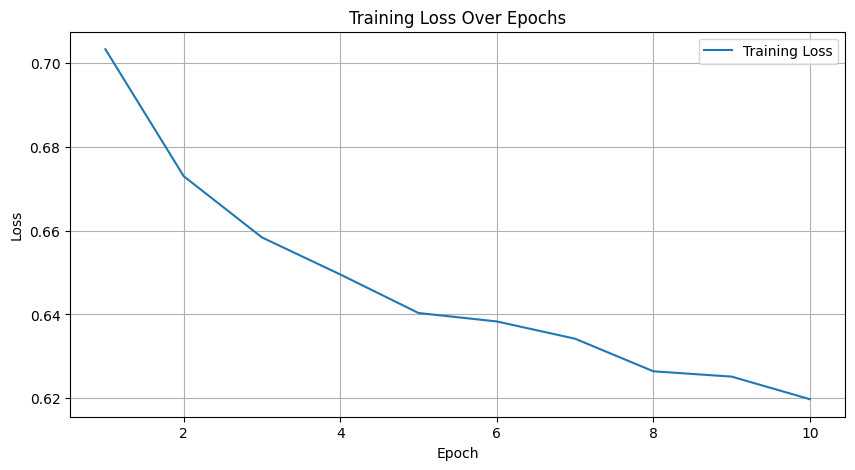

Ablating feature GCS - Motor Response (3/10)
Epoch 1/10, Loss: 0.7508
Epoch 2/10, Loss: 0.6687
Epoch 3/10, Loss: 0.6585
Epoch 4/10, Loss: 0.6403
Epoch 5/10, Loss: 0.6401
Epoch 6/10, Loss: 0.6243
Epoch 7/10, Loss: 0.6227
Epoch 8/10, Loss: 0.6250
Epoch 9/10, Loss: 0.6233
Epoch 10/10, Loss: 0.6163


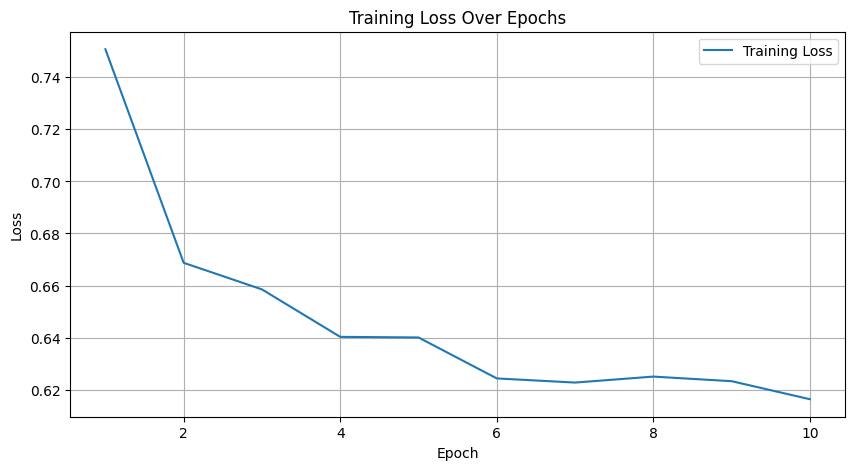

Ablating feature Tidal Volume (observed) (4/10)
Epoch 1/10, Loss: 0.7318
Epoch 2/10, Loss: 0.6785
Epoch 3/10, Loss: 0.6554
Epoch 4/10, Loss: 0.6402
Epoch 5/10, Loss: 0.6414
Epoch 6/10, Loss: 0.6310
Epoch 7/10, Loss: 0.6346
Epoch 8/10, Loss: 0.6250
Epoch 9/10, Loss: 0.6190
Epoch 10/10, Loss: 0.6202


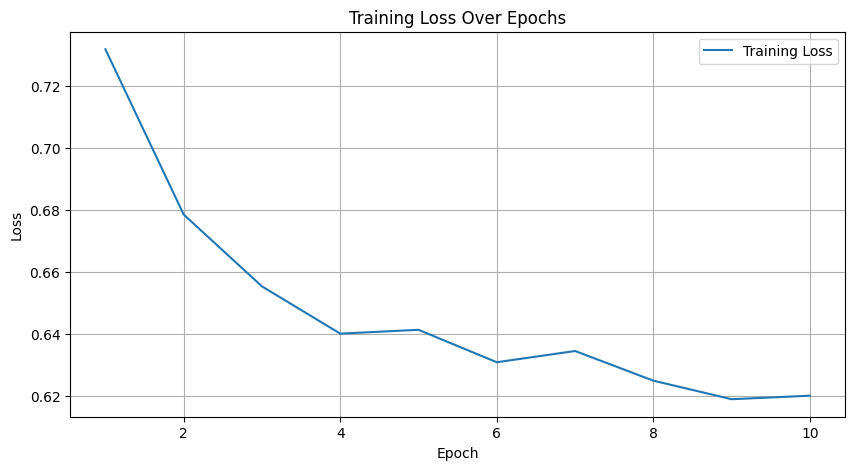

Ablating feature Minute Volume (5/10)
Epoch 1/10, Loss: 0.7133
Epoch 2/10, Loss: 0.6772
Epoch 3/10, Loss: 0.6595
Epoch 4/10, Loss: 0.6391
Epoch 5/10, Loss: 0.6414
Epoch 6/10, Loss: 0.6330
Epoch 7/10, Loss: 0.6269
Epoch 8/10, Loss: 0.6299
Epoch 9/10, Loss: 0.6277
Epoch 10/10, Loss: 0.6205


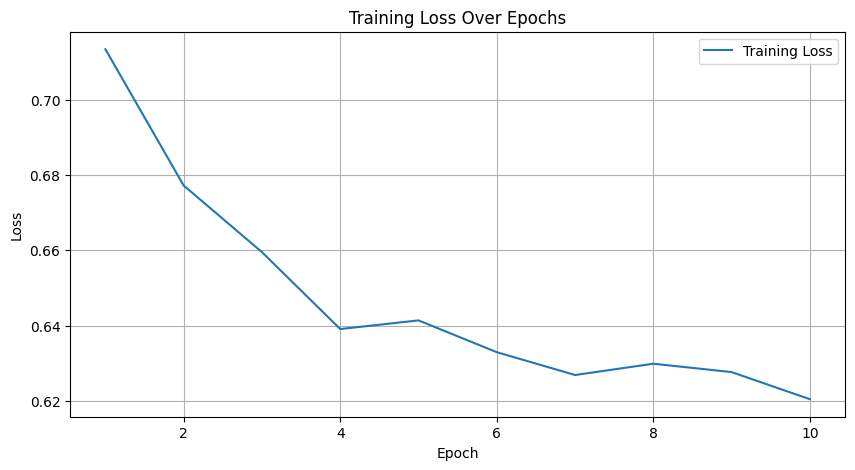

Ablating feature Mean Airway Pressure (6/10)
Epoch 1/10, Loss: 0.7013
Epoch 2/10, Loss: 0.6638
Epoch 3/10, Loss: 0.6532
Epoch 4/10, Loss: 0.6407
Epoch 5/10, Loss: 0.6363
Epoch 6/10, Loss: 0.6336
Epoch 7/10, Loss: 0.6257
Epoch 8/10, Loss: 0.6243
Epoch 9/10, Loss: 0.6210
Epoch 10/10, Loss: 0.6213


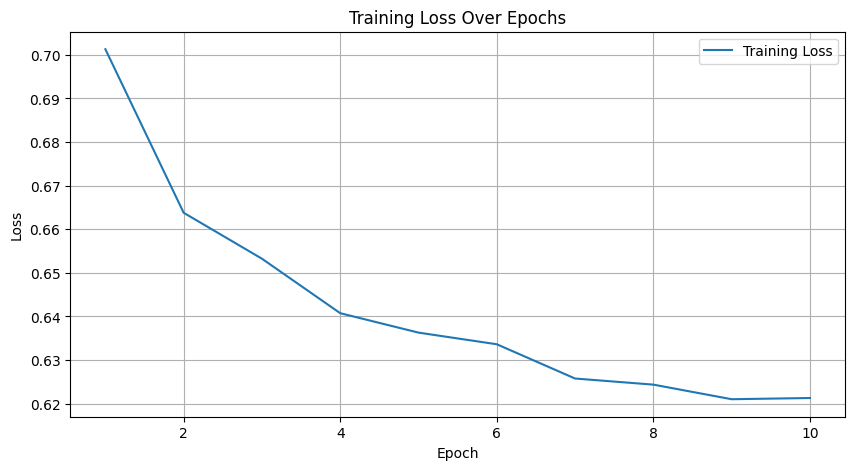

Ablating feature Peak Insp. Pressure (7/10)
Epoch 1/10, Loss: 0.7065
Epoch 2/10, Loss: 0.6753
Epoch 3/10, Loss: 0.6528
Epoch 4/10, Loss: 0.6478
Epoch 5/10, Loss: 0.6421
Epoch 6/10, Loss: 0.6264
Epoch 7/10, Loss: 0.6240
Epoch 8/10, Loss: 0.6211
Epoch 9/10, Loss: 0.6256
Epoch 10/10, Loss: 0.6220


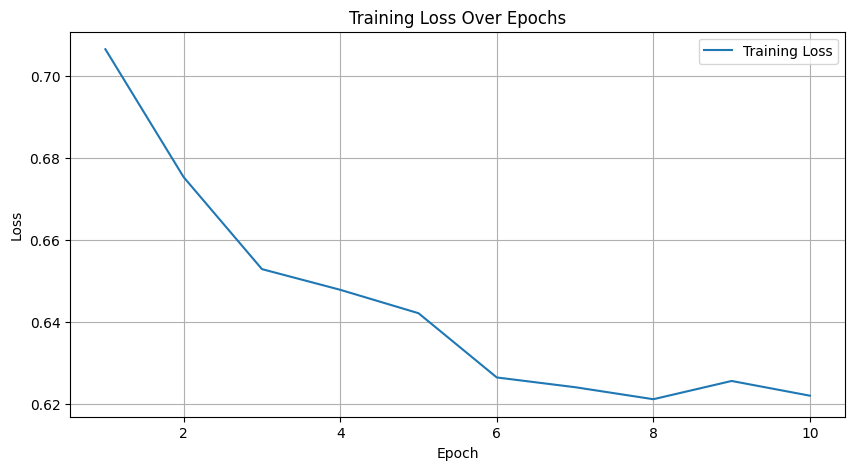

Ablating feature Temperature Fahrenheit (8/10)
Epoch 1/10, Loss: 0.6969
Epoch 2/10, Loss: 0.6545
Epoch 3/10, Loss: 0.6502
Epoch 4/10, Loss: 0.6377
Epoch 5/10, Loss: 0.6393
Epoch 6/10, Loss: 0.6336
Epoch 7/10, Loss: 0.6182
Epoch 8/10, Loss: 0.6268
Epoch 9/10, Loss: 0.6237
Epoch 10/10, Loss: 0.6177


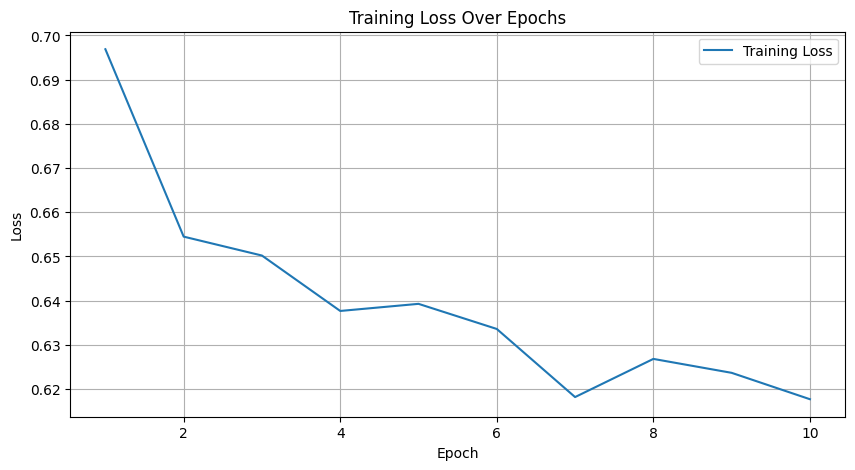

Ablating feature Tidal Volume (spontaneous) (9/10)
Epoch 1/10, Loss: 0.6926
Epoch 2/10, Loss: 0.6652
Epoch 3/10, Loss: 0.6544
Epoch 4/10, Loss: 0.6561
Epoch 5/10, Loss: 0.6436
Epoch 6/10, Loss: 0.6276
Epoch 7/10, Loss: 0.6258
Epoch 8/10, Loss: 0.6177
Epoch 9/10, Loss: 0.6224
Epoch 10/10, Loss: 0.6168


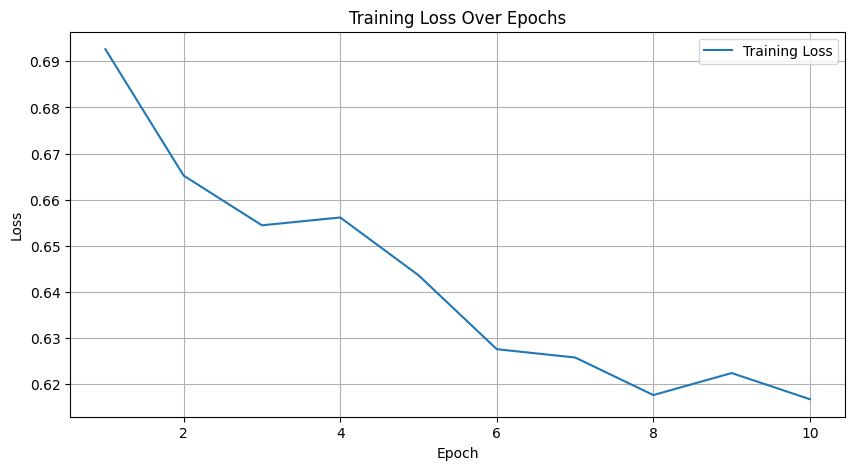

Ablating feature Richmond-RAS Scale (10/10)
Epoch 1/10, Loss: 0.7212
Epoch 2/10, Loss: 0.6689
Epoch 3/10, Loss: 0.6643
Epoch 4/10, Loss: 0.6508
Epoch 5/10, Loss: 0.6414
Epoch 6/10, Loss: 0.6445
Epoch 7/10, Loss: 0.6299
Epoch 8/10, Loss: 0.6260
Epoch 9/10, Loss: 0.6232
Epoch 10/10, Loss: 0.6217


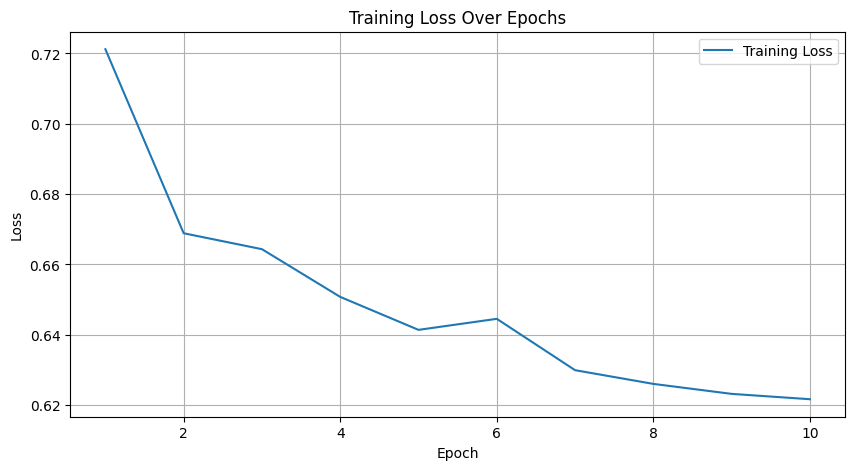

Ablating feature Heart Rate (1/6)
Epoch 1/10, Loss: 0.7063
Epoch 2/10, Loss: 0.6617
Epoch 3/10, Loss: 0.6576
Epoch 4/10, Loss: 0.6485
Epoch 5/10, Loss: 0.6339
Epoch 6/10, Loss: 0.6365
Epoch 7/10, Loss: 0.6282
Epoch 8/10, Loss: 0.6293
Epoch 9/10, Loss: 0.6193
Epoch 10/10, Loss: 0.6142


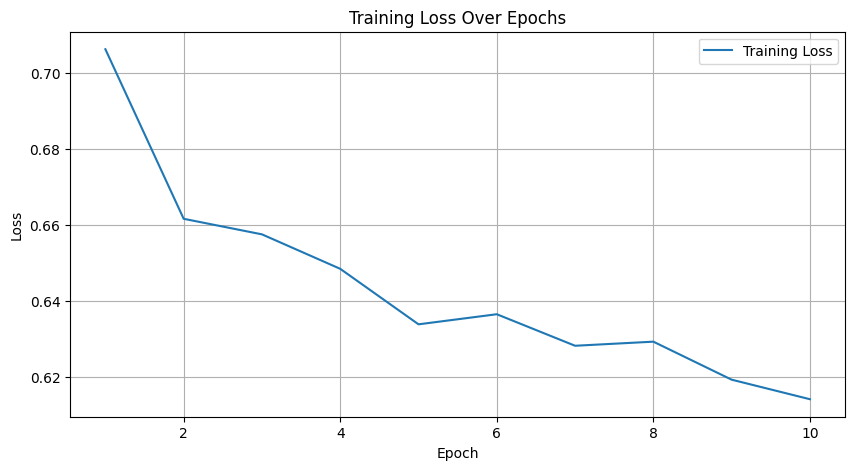

Ablating feature O2 saturation pulseoxymetry (2/6)
Epoch 1/10, Loss: 0.7327
Epoch 2/10, Loss: 0.6773
Epoch 3/10, Loss: 0.6729
Epoch 4/10, Loss: 0.6510
Epoch 5/10, Loss: 0.6446
Epoch 6/10, Loss: 0.6358
Epoch 7/10, Loss: 0.6262
Epoch 8/10, Loss: 0.6258
Epoch 9/10, Loss: 0.6210
Epoch 10/10, Loss: 0.6231


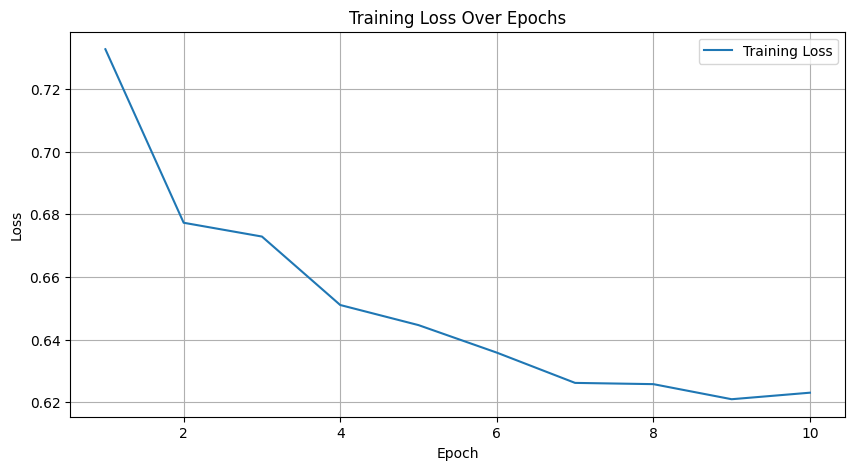

Ablating feature Respiratory Rate (3/6)
Epoch 1/10, Loss: 0.7064
Epoch 2/10, Loss: 0.6724
Epoch 3/10, Loss: 0.6534
Epoch 4/10, Loss: 0.6524
Epoch 5/10, Loss: 0.6372
Epoch 6/10, Loss: 0.6374
Epoch 7/10, Loss: 0.6349
Epoch 8/10, Loss: 0.6299
Epoch 9/10, Loss: 0.6286
Epoch 10/10, Loss: 0.6204


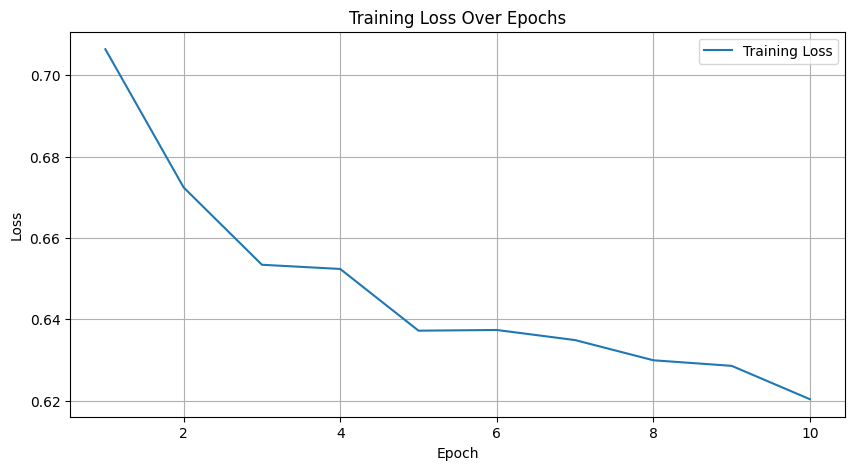

Ablating feature Arterial Blood Pressure mean (4/6)
Epoch 1/10, Loss: 0.7353
Epoch 2/10, Loss: 0.6833
Epoch 3/10, Loss: 0.6594
Epoch 4/10, Loss: 0.6514
Epoch 5/10, Loss: 0.6387
Epoch 6/10, Loss: 0.6290
Epoch 7/10, Loss: 0.6335
Epoch 8/10, Loss: 0.6207
Epoch 9/10, Loss: 0.6196
Epoch 10/10, Loss: 0.6170


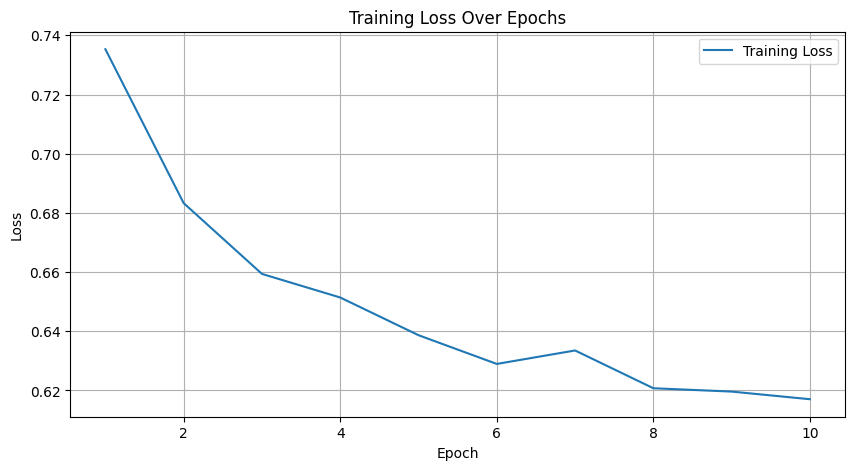

Ablating feature Arterial Blood Pressure diastolic (5/6)
Epoch 1/10, Loss: 0.7417
Epoch 2/10, Loss: 0.6810
Epoch 3/10, Loss: 0.6565
Epoch 4/10, Loss: 0.6426
Epoch 5/10, Loss: 0.6449
Epoch 6/10, Loss: 0.6301
Epoch 7/10, Loss: 0.6283
Epoch 8/10, Loss: 0.6238
Epoch 9/10, Loss: 0.6232
Epoch 10/10, Loss: 0.6266


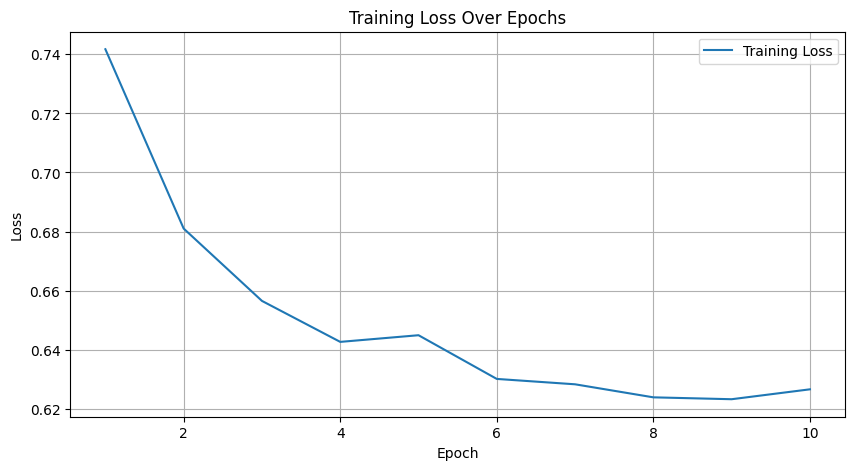

Ablating feature Arterial Blood Pressure systolic (6/6)
Epoch 1/10, Loss: 0.7048
Epoch 2/10, Loss: 0.6736
Epoch 3/10, Loss: 0.6556
Epoch 4/10, Loss: 0.6425
Epoch 5/10, Loss: 0.6398
Epoch 6/10, Loss: 0.6350
Epoch 7/10, Loss: 0.6288
Epoch 8/10, Loss: 0.6282
Epoch 9/10, Loss: 0.6225
Epoch 10/10, Loss: 0.6174


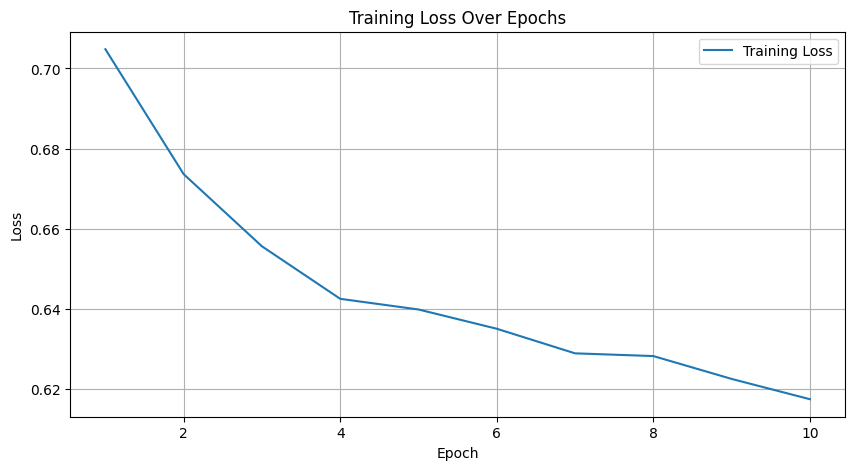

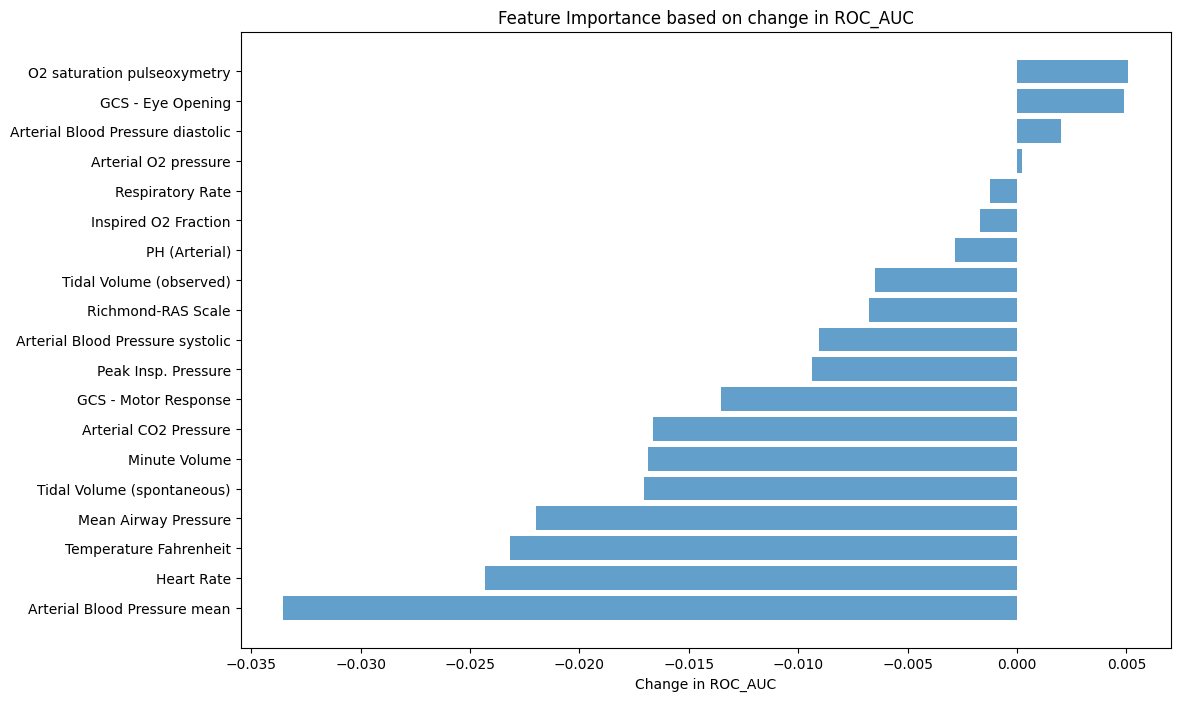

In [ ]:
# Execute feature ablation
feature_importances = feature_ablation_with_names(
    train_low_sequences_resampled,
    train_medium_sequences_resampled,
    train_high_sequences_resampled,
    train_labels_resampled,
    low_freq_test_sequences,
    medium_freq_test_sequences,
    high_freq_test_sequences,
    labels_test,
    final_model,
    best_params,
    device,
    low_freq_feature_names,
    medium_freq_feature_names,
    high_freq_feature_names
)

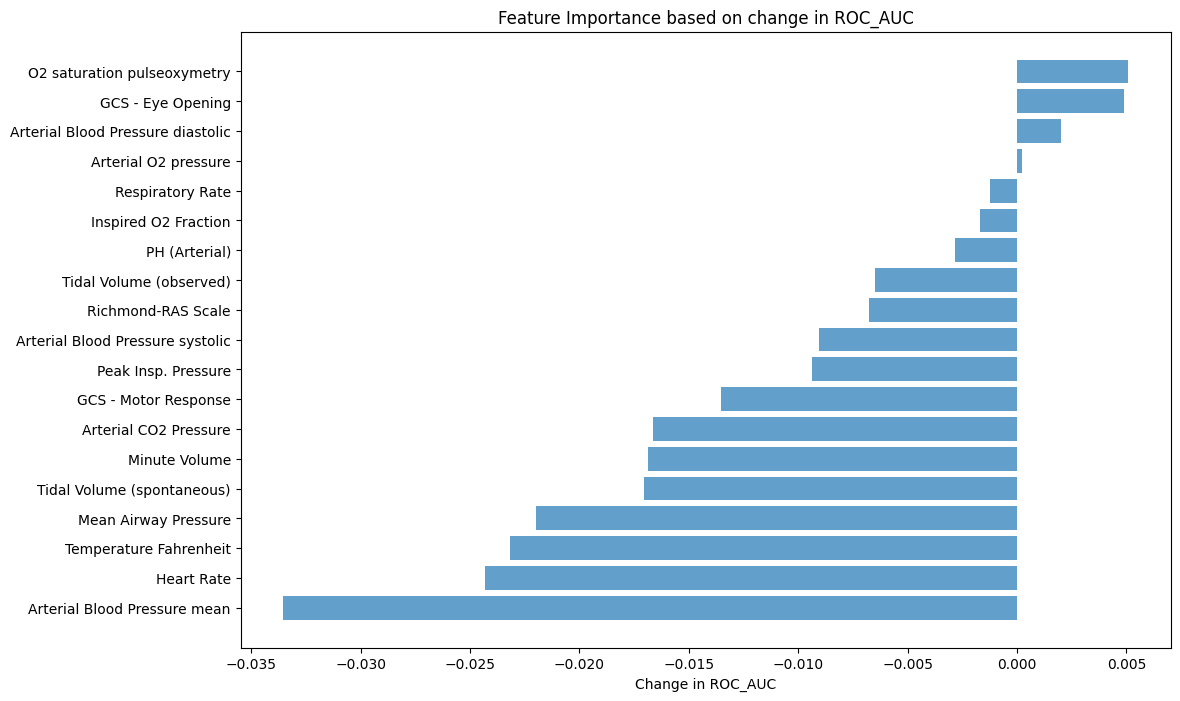